# TREC-6 question classification Dataset

Obtained from https://cogcomp.seas.upenn.edu/Data/QA/QC/ (Training set 5 + Test set)
```
@inproceedings{li2002learning,
  title={Learning question classifiers},
  author={Li, Xin and Roth, Dan},
  booktitle={COLING 2002: The 19th International Conference on Computational Linguistics},
  year={2002}
}
```

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import hashlib

TRAIN_DATASET_LOCATION = "../datasets/trec/train_5500.label"
TEST_DATASET_LOCATION = "../datasets/trec/TREC_10.label"

### Validity check

In [2]:
VERIFY_CHECKSUM = True

In [3]:
assert os.path.exists(TRAIN_DATASET_LOCATION)
assert os.path.exists(TEST_DATASET_LOCATION)

def verify_checksum(file, checksum):
    with open(file, "rb") as f:
        file_hash = hashlib.md5()
        while chunk := f.read(8192):
            file_hash.update(chunk)
    assert checksum == file_hash.hexdigest()
    print("Checksum matches")
    
if VERIFY_CHECKSUM:
    verify_checksum(TRAIN_DATASET_LOCATION, '073462e3fcefaae31e00edb1f18d2d02')
    verify_checksum(TEST_DATASET_LOCATION, '323a3554401d86e650717e2d2f942589')

Checksum matches
Checksum matches


### Read data

In [4]:
def read_trec(path, nrows=None, remove_subcategory=True):
    with open(path, "r") as f:
        lines = []
        nrow = 0
        for line in f:
            category, text = line.strip().split(" ", 1)
            category = category.split(":")[0] if remove_subcategory else category
            lines.append([category, text])
            nrow += 1
            if nrows and nrow >= nrows:
                break
            
    return pd.DataFrame(lines)

read_trec(TRAIN_DATASET_LOCATION, 10, remove_subcategory=False)

,0,1
0,DESC:manner,How did serfdom develop in and then leave Russ...
1,ENTY:cremat,What films featured the character Popeye Doyle ?
2,DESC:manner,How can I find a list of celebrities ' real na...
3,ENTY:animal,What fowl grabs the spotlight after the Chines...
4,ABBR:exp,What is the full form of .com ?
5,HUM:ind,What contemptible scoundrel stole the cork fro...
6,HUM:gr,What team did baseball 's St. Louis Browns bec...
7,HUM:title,What is the oldest profession ?
8,DESC:def,What are liver enzymes ?
9,HUM:ind,Name the scar-faced bounty hunter of The Old W...


In [5]:
df_trec_train = read_trec(TRAIN_DATASET_LOCATION)
df_trec_train.columns = ['target', 'text']
df_trec_train.shape

(5452, 2)

In [6]:
df_trec_train.head()

,target,text
0,DESC,How did serfdom develop in and then leave Russ...
1,ENTY,What films featured the character Popeye Doyle ?
2,DESC,How can I find a list of celebrities ' real na...
3,ENTY,What fowl grabs the spotlight after the Chines...
4,ABBR,What is the full form of .com ?


In [25]:
1250/5452

0.2292736610418195

Text(0.5, 0, 'Count')

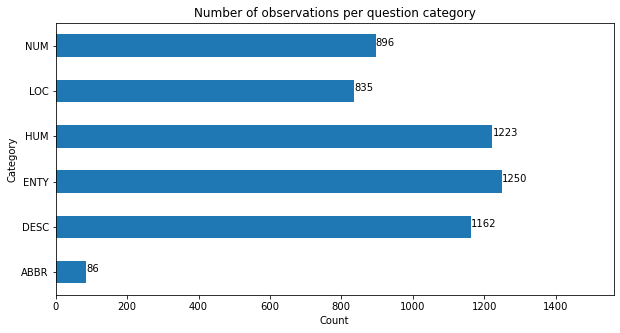

In [7]:
vc = df_trec_train.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per question category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export File

In [8]:
PREPROCESSED_FILE = '../datasets/preprocessed/trec_train.csv'
df_trec_train.to_csv(PREPROCESSED_FILE, index=False)

### Detect Non-English texts

In [9]:
import fasttext
import numpy as np
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

LANGUAGE_DETECTION_MODEL = "../fasttext/language_identification/lid.176.bin" #https://fasttext.cc/docs/en/language-identification.html
model = fasttext.load_model(LANGUAGE_DETECTION_MODEL)

In [10]:
def get_language(paragraph, k=None, return_all=False, min_certainty=0.25):
    if pd.isna(paragraph):
        return np.nan
    sentences = [line for line in paragraph.split("\n") if line != '']
    if len(sentences) < 1:
        return np.nan
    class_labels, certainties = model.predict(sentences, k)
    # sum certainties per class label and then divide by length -> avg certainty
    class_lookup, indexed_lang = np.unique(np.hstack(class_labels), return_inverse=True)
    summed_certainties = np.bincount(indexed_lang, weights=np.hstack(certainties))/len(sentences)
    if return_all:
        return dict(zip(class_lookup, summed_certainties))
    
    # get most likely lang
    lang_id = np.argmax(summed_certainties)
    if summed_certainties[lang_id] < min_certainty:
        return np.nan
    return class_lookup[lang_id]        

In [11]:
df_trec_train['lang'] = df_trec_train.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/5452 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

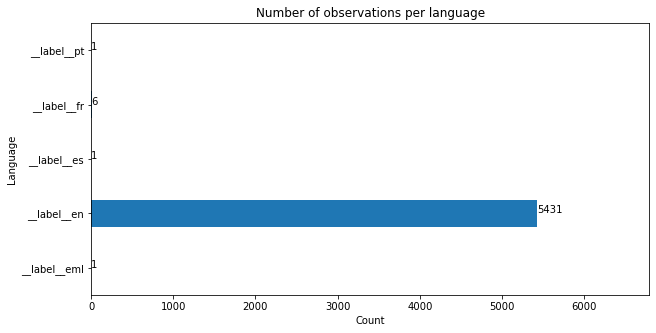

In [12]:
vc = df_trec_train.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [13]:
vc.nlargest(5)

__label__en     5431
__label__fr        6
__label__eml       1
__label__es        1
__label__pt        1
Name: lang, dtype: int64

In [14]:
f"{vc['__label__en']/df_trec_train.shape[0]*100:.4f}% of samples are english" 

'99.6148% of samples are english'

In [15]:
df_trec_train[df_trec_train.lang != '__label__en']

,target,text,lang
148,HUM,Who produces Spumante ?,NaN
200,HUM,Name Alvin 's brothers,NaN
325,NUM,What is the latitude and longitude of El Paso ...,__label__fr
361,DESC,Define the Pheonix Club ?,NaN
470,LOC,Where do hyenas live ?,__label__pt
1360,HUM,Who sells Viagra ?,NaN
1422,ENTY,Name Li 'l Abner 's favorite Indian drink .,NaN
1535,NUM,What is the latitude and longitude of El Paso ...,__label__fr
1943,DESC,What 's the Red Planet ?,NaN
2164,DESC,Why can 't ostriches fly ?,__label__eml


### Test Set analysis

In [16]:
df_trec_test = read_trec(TEST_DATASET_LOCATION)
df_trec_test.columns = ['target', 'text']
df_trec_test.shape

(500, 2)

In [17]:
df_trec_test.head()

,target,text
0,NUM,How far is it from Denver to Aspen ?
1,LOC,"What county is Modesto , California in ?"
2,HUM,Who was Galileo ?
3,DESC,What is an atom ?
4,NUM,When did Hawaii become a state ?


Text(0.5, 0, 'Count')

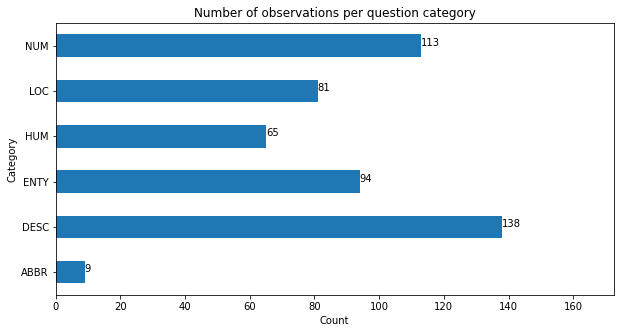

In [18]:
vc = df_trec_test.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per question category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export file

In [19]:
PREPROCESSED_FILE = '../datasets/preprocessed/trec_test.csv'
df_trec_test.to_csv(PREPROCESSED_FILE, index=False)

In [20]:
df_trec_test['lang'] = df_trec_test.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

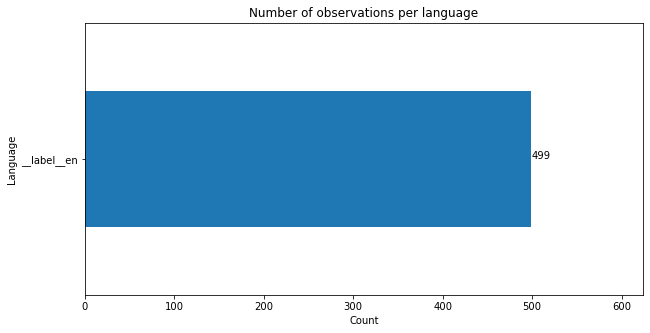

In [21]:
vc = df_trec_test.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [22]:
vc.nlargest(5)

__label__en    499
Name: lang, dtype: int64

In [23]:
f"{vc['__label__en']/df_trec_test.shape[0]*100:.4f}% of samples are english" 

'99.8000% of samples are english'